# Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

from pandas.tseries.offsets import DateOffset

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

import warnings
warnings.filterwarnings("ignore")

# Dataset

In [2]:
# read dataset
df = pd.read_csv('deaths_pivot.csv')
df.head()

,country,date,total
0,Afghanistan,2021-01-01,2191
1,Afghanistan,2021-01-10,2277
2,Afghanistan,2021-01-11,2288
3,Afghanistan,2021-01-12,2301
4,Afghanistan,2021-01-13,2301


In [3]:
# selecting datas only from Singapore
mask = df.loc[df['country'] == 'Singapore']
sg_dataset = pd.DataFrame(mask,columns=['date','total'])
sg_dataset.head()

,date,total
65410,2021-01-01,29
65411,2021-01-10,29
65412,2021-01-11,29
65413,2021-01-12,29
65414,2021-01-13,29


In [4]:
# check for null values
sg_dataset.isna().sum()

date     0
total    0
dtype: int64

In [5]:
# convert date datatype to datetime
sg_dataset['date']=pd.to_datetime(sg_dataset['date'])
sg_dataset.dtypes

date     datetime64[ns]
total             int64
dtype: object

In [6]:
# set converting the dataset to monthly frequency
sg_dataset.set_index('date',inplace=True)
sg_dataset

,total
date,
2021-01-01,29
2021-01-10,29
2021-01-11,29
2021-01-12,29
2021-01-13,29
...,...
2020-09-05,27
2020-09-06,27
2020-09-07,27


In [7]:
sg_dataW = sg_dataset['total'].resample('W').interpolate().to_frame()
sg_dataW = sg_dataW.fillna(0)
print("Weekly:\n",sg_dataW)

sg_dataMS = sg_dataset['total'].resample('MS').interpolate().to_frame()
sg_dataMS = sg_dataMS.fillna(0)
print("Monthly:\n",sg_dataMS)

Weekly:
             total
date             
2020-01-26    0.0
2020-02-02    0.0
2020-02-09    0.0
2020-02-16    0.0
2020-02-23    0.0
...           ...
2021-02-21   29.0
2021-02-28   29.0
2021-03-07   29.0
2021-03-14   30.0
2021-03-21   30.0

[61 rows x 1 columns]
Monthly:
             total
date             
2020-01-01    0.0
2020-02-01    0.0
2020-03-01    0.0
2020-04-01    3.0
2020-05-01   16.0
2020-06-01   24.0
2020-07-01   26.0
2020-08-01   27.0
2020-09-01   27.0
2020-10-01   27.0
2020-11-01   28.0
2020-12-01   29.0
2021-01-01   29.0
2021-02-01   29.0
2021-03-01   29.0


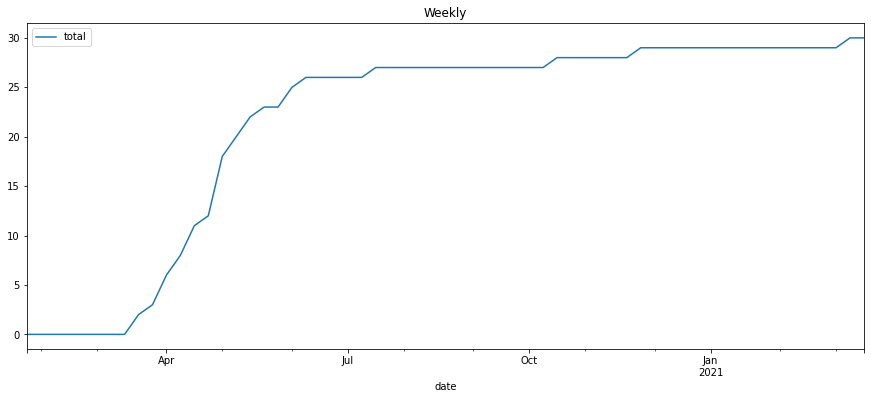

In [8]:
sg_dataW.plot(figsize=(15, 6))
plt.title("Weekly")
plt.show()

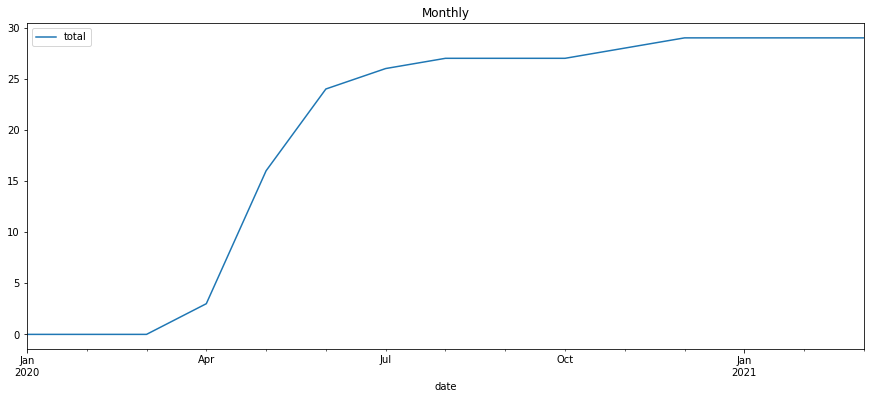

In [9]:
sg_dataMS.plot(figsize=(15, 6))
plt.title("Monthly")
plt.show()

# ARIMA

In [10]:
# function in order to determine if it is stationary or non stationary where Ho means non stationary and H1 means stationary

def adfuller_test(data):
    result=adfuller(data)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [11]:
adfuller_test(sg_dataW['total'])

ADF Test Statistic : -4.784921869743496
p-value : 5.811548066021683e-05
#Lags Used : 8
Number of Observations Used : 52
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [12]:
adfuller_test(sg_dataMS['total'])

ADF Test Statistic : -3.941757233981698
p-value : 0.0017481483095022332
#Lags Used : 5
Number of Observations Used : 9
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


# Differencing

Since the dataset is already stationary, differencing is not needed

# Auto Regressive Model

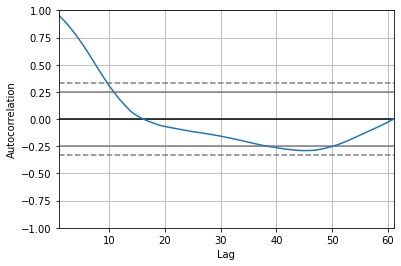

In [13]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(sg_dataW['total'])
plt.show()

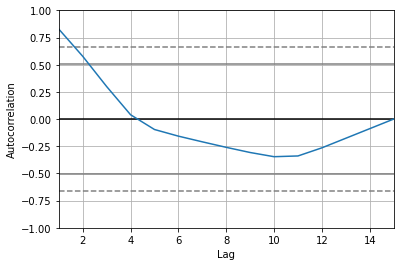

In [14]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(sg_dataMS['total'])
plt.show()

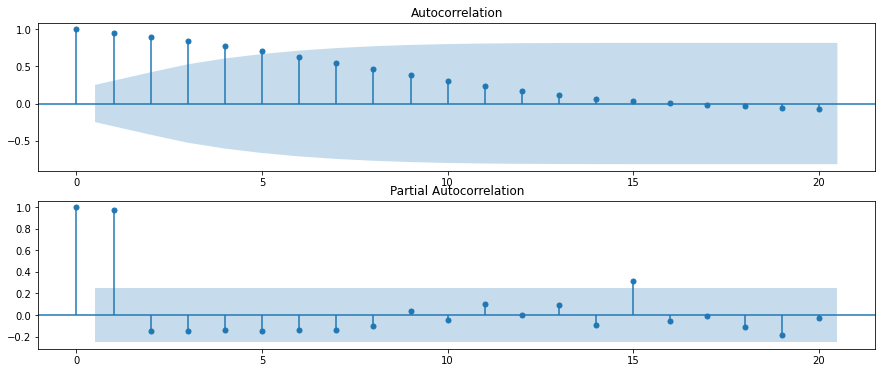

In [15]:
#Weekly
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sg_dataW['total'],lags=20,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sg_dataW['total'],lags=20,ax=ax2)

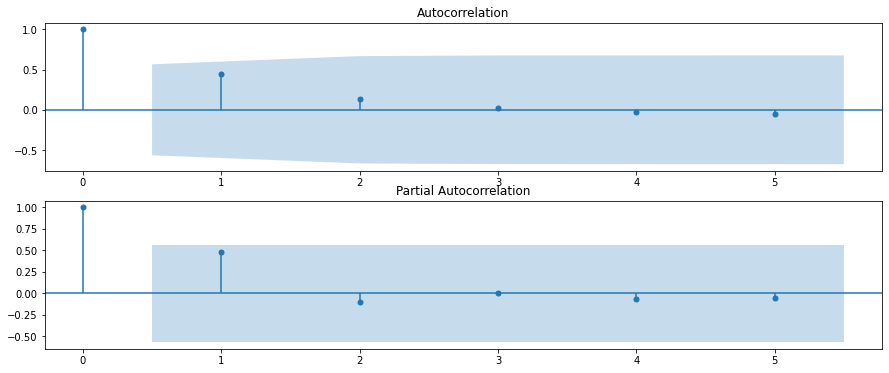

In [16]:
#Monthly
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sg_dataMS['total'].iloc[3:],lags=5,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sg_dataMS['total'].iloc[3:],lags=5,ax=ax2)

In [17]:
##p=1, d=0, q=0
w_model=ARIMA(sg_dataW['total'],order=(1,0,0))
w_model_fit=w_model.fit()
w_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  total   No. Observations:                   61
Model:                     ARMA(1, 0)   Log Likelihood                 -98.573
Method:                       css-mle   S.D. of innovations              1.168
Date:                Fri, 19 Mar 2021   AIC                            203.146
Time:                        20:22:50   BIC                            209.478
Sample:                    01-26-2020   HQIC                           205.628
                         - 03-21-2021                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          15.5905     13.941      1.118      0.263     -11.733      42.914
ar.L1.total     0.9968      0.004    230.903      0.000       0.988       1.005
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0032           +0.0000j            1.0032            0.0000
-----------------------------------------------------------------------------
"""

In [18]:
##p=1, d=0, q=0
m_model=ARIMA(sg_dataMS['total'],order=(1,0,0))
m_model_fit=m_model.fit()
m_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  total   No. Observations:                   15
Model:                     ARMA(1, 0)   Log Likelihood                 -43.912
Method:                       css-mle   S.D. of innovations              4.177
Date:                Fri, 19 Mar 2021   AIC                             93.825
Time:                        20:22:51   BIC                             95.949
Sample:                    01-01-2020   HQIC                            93.802
                         - 03-01-2021                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          15.8984     11.844      1.342      0.179      -7.315      39.112
ar.L1.total     0.9520      0.057     16.691      0.000       0.840       1.064
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0504           +0.0000j            1.0504            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:xlabel='date'>

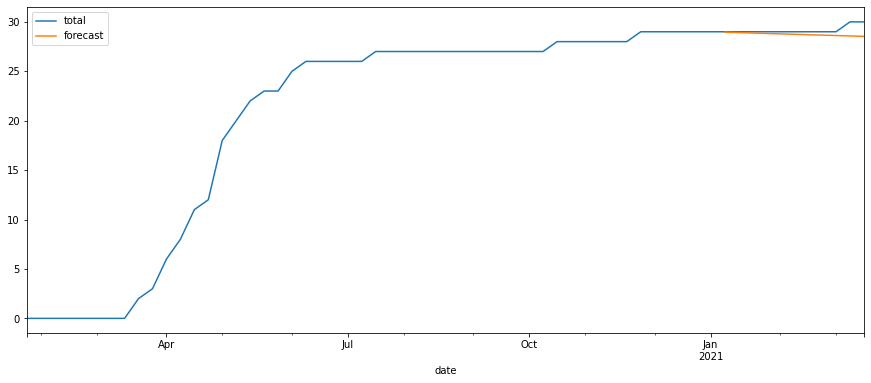

In [19]:
sg_dataW['forecast']=w_model_fit.predict(start=50,end=60,dynamic=True)
sg_dataW[['total','forecast']].plot(figsize=(15, 6))

<AxesSubplot:xlabel='date'>

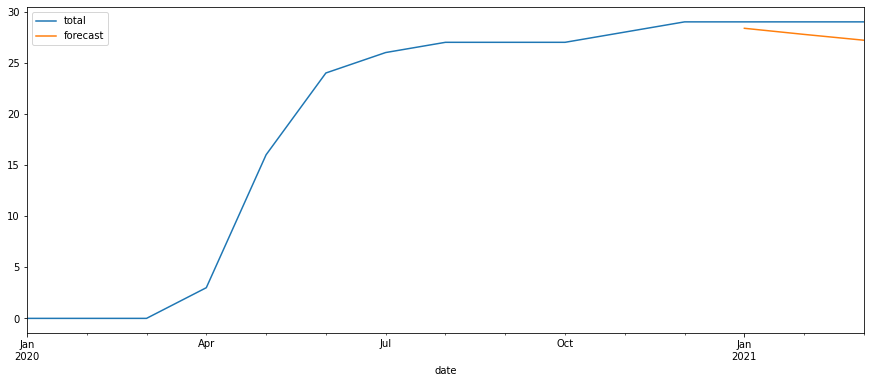

In [20]:
sg_dataMS['forecast']=m_model_fit.predict(start=12,end=15,dynamic=True)
sg_dataMS[['total','forecast']].plot(figsize=(15, 6))

# SARIMAX

In [21]:
import itertools

pW = dW = qW = range(0, 2)
pdqW = list(itertools.product(pW, dW, qW))
seasonal_pdqW = [(x[0], x[1], x[2], 30) for x in list(itertools.product(pW, dW, qW))]

pMS = dMS = qMS = range(0, 2)
pdqMS = list(itertools.product(pMS, dMS, qMS))
seasonal_pdqMS = [(x[0], x[1], x[2], 30) for x in list(itertools.product(pMS, dMS, qMS))]


In [22]:
yW = sg_dataset['total'].resample('W').mean()
yMS = sg_dataset['total'].resample('MS').mean()

print(yW,"\n\n",yMS)

date
2020-01-26     0.000000
2020-02-02     0.000000
2020-02-09     0.000000
2020-02-16     0.000000
2020-02-23     0.000000
                ...    
2021-02-21    29.000000
2021-02-28    29.000000
2021-03-07    29.000000
2021-03-14    29.285714
2021-03-21    30.000000
Freq: W-SUN, Name: total, Length: 61, dtype: float64 

 date
2020-01-01     0.000000
2020-02-01     0.000000
2020-03-01     0.806452
2020-04-01     9.400000
2020-05-01    21.129032
2020-06-01    25.433333
2020-07-01    26.580645
2020-08-01    27.000000
2020-09-01    27.000000
2020-10-01    27.645161
2020-11-01    28.100000
2020-12-01    29.000000
2021-01-01    29.000000
2021-02-01    29.000000
2021-03-01    29.333333
Freq: MS, Name: total, dtype: float64


In [23]:
for paramW in pdqW:
    for param_seasonalW in seasonal_pdqW:
        try:
            modW = sm.tsa.statespace.SARIMAX(yW,
                                            order=paramW,
                                            seasonal_order=param_seasonalW,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            resultsW = modW.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(paramW, param_seasonalW, resultsW.aic))
        except:
            continue

print("\n=====\n")

for paramMS in pdqMS:
    for param_seasonalMS in seasonal_pdqMS:
        try:
            modMS = sm.tsa.statespace.SARIMAX(yMS,
                                            order=paramMS,
                                            seasonal_order=param_seasonalMS,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            resultsMS = modMS.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(paramMS, param_seasonalMS, resultsMS.aic))
        except:
            continue            


ARIMA(0, 0, 0)x(0, 0, 0, 30)12 - AIC:554.1519084920251
ARIMA(0, 0, 0)x(0, 0, 1, 30)12 - AIC:289.85846248671805
ARIMA(0, 0, 0)x(0, 1, 0, 30)12 - AIC:256.93812400516254
ARIMA(0, 0, 0)x(0, 1, 1, 30)12 - AIC:4.0
ARIMA(0, 0, 0)x(1, 0, 0, 30)12 - AIC:267.096805697595
ARIMA(0, 0, 0)x(1, 0, 1, 30)12 - AIC:259.0008935322459
ARIMA(0, 0, 0)x(1, 1, 0, 30)12 - AIC:-11.198993952137435
ARIMA(0, 0, 0)x(1, 1, 1, 30)12 - AIC:6.0
ARIMA(0, 0, 1)x(0, 0, 0, 30)12 - AIC:471.08113148911406
ARIMA(0, 0, 1)x(0, 0, 1, 30)12 - AIC:246.63107233076377
ARIMA(0, 0, 1)x(0, 1, 0, 30)12 - AIC:210.70796768110444
ARIMA(0, 0, 1)x(0, 1, 1, 30)12 - AIC:6.0
ARIMA(0, 0, 1)x(1, 0, 0, 30)12 - AIC:230.97767114504506
ARIMA(0, 0, 1)x(1, 0, 1, 30)12 - AIC:215.55557549460178
ARIMA(0, 0, 1)x(1, 1, 0, 30)12 - AIC:-13.951344605089297
ARIMA(0, 0, 1)x(1, 1, 1, 30)12 - AIC:8.0
ARIMA(0, 1, 0)x(0, 0, 0, 30)12 - AIC:178.8987424435437
ARIMA(0, 1, 0)x(0, 0, 1, 30)12 - AIC:11.296103429206514
ARIMA(0, 1, 0)x(0, 1, 0, 30)12 - AIC:105.52061564145787

In [24]:
modelW=sm.tsa.statespace.SARIMAX(yW,order=(1, 1, 1),seasonal_order=(0,0,0,12), enforce_invertibility=False)
resultsW=modelW.fit()

print(resultsW.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8856      0.038     23.105      0.000       0.810       0.961
ma.L1         -0.2316      0.093     -2.498      0.012      -0.413      -0.050
sigma2         0.3571      0.050      7.126      0.000       0.259       0.455


In [25]:
modelMS=sm.tsa.statespace.SARIMAX(yMS,order=(1, 1, 1),seasonal_order=(0,0,0,12), enforce_invertibility=False)
resultsMS=modelMS.fit()

print(resultsMS.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4284      0.227      1.889      0.059      -0.016       0.873
ma.L1          1.0000      2e+04   4.99e-05      1.000   -3.92e+04    3.93e+04
sigma2         4.2573   8.53e+04   4.99e-05      1.000   -1.67e+05    1.67e+05


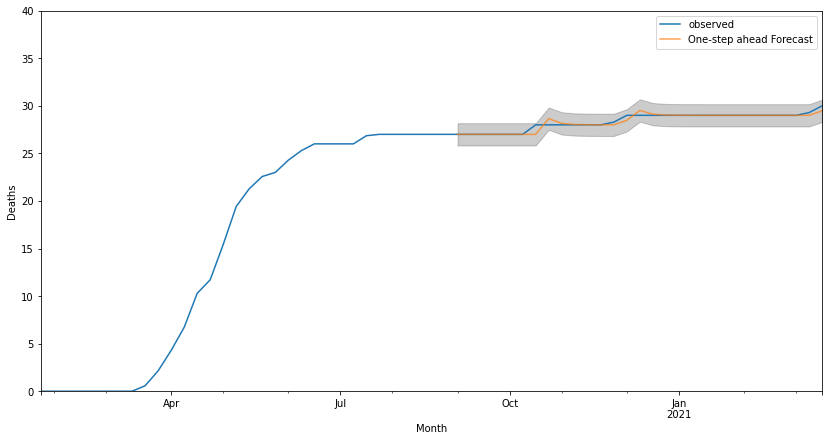

In [26]:
predW = resultsW.get_prediction(start=pd.to_datetime('2020-09-06'), dynamic=False)
pred_ci = predW.conf_int()
ax = yW['2020':].plot(label='observed')
predW.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Month')
ax.set_ylabel('Deaths')
plt.ylim(0, 40)
plt.legend()
plt.show()

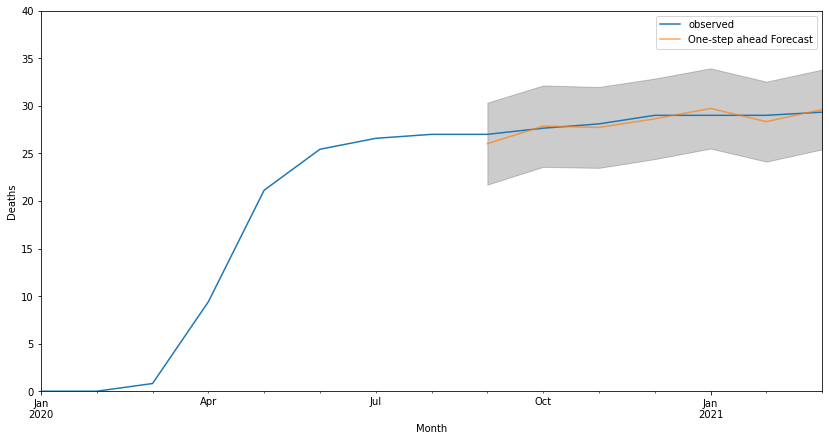

In [27]:
predMS = resultsMS.get_prediction(start=pd.to_datetime('2020-09-01'), dynamic=False)
pred_ci = predMS.conf_int()
ax = yMS['2020':].plot(label='observed')
predMS.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Month')
ax.set_ylabel('Deaths')
plt.ylim(0, 40)
plt.legend()
plt.show()

# Future prediction

# Producing and visualizing forecasts

In [28]:
y_forecasted = predW.predicted_mean
y_truth = yW['2020-09-06':]
mseW = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts(WEEKLY) is {}'.format(round(mseW, 2)))

y_forecasted = predMS.predicted_mean
y_truth = yMS['2020-09-01':]
mseMS = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts(MONTHLY) is {}'.format(round(mseMS, 2)))

The Mean Squared Error of our forecasts(WEEKLY) is 0.08
The Mean Squared Error of our forecasts(MONTHLY) is 0.33


In [29]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mseW), 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mseMS), 2)))

The Root Mean Squared Error of our forecasts is 0.29
The Root Mean Squared Error of our forecasts is 0.58


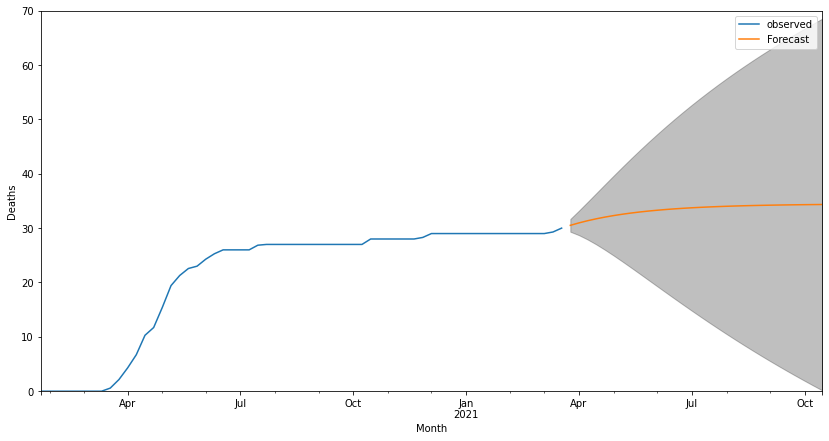

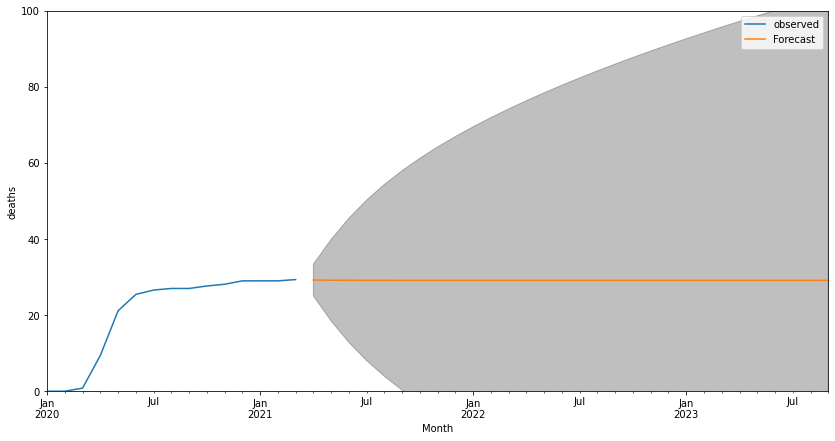

In [30]:
pred_uc = resultsW.get_forecast(steps=30)
pred_ci = pred_uc.conf_int()
ax = yW.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Month')
ax.set_ylabel('Deaths')
plt.ylim(0, 70)
plt.legend()
plt.show()

pred_uc = resultsMS.get_forecast(steps=30)
pred_ci = pred_uc.conf_int()
ax = yMS.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Month')
ax.set_ylabel('deaths')
plt.ylim(0, 100)
plt.legend()
plt.show()